# SOFIA/FORCAST Galactic Center SSTGC X-match Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [2]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt

from astroquery.vizier import Vizier
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, hstack
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.coordinates.matching import _get_cartesian_kdtree
from astropy.table import join, vstack, Table

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
#from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *


In [4]:
from FORCASTphot import makeDS9reg, findNOTindex

## Load in catalog from file

In [60]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [61]:
#load in the master catalogs
mcat=Table.read('masterCat_step3_combined_update420.fits')

In [62]:
#add sky coord column if not already present
if 'skycoords' not in mcat.columns:

    ras=mcat["RA(J2000)"]
    decs=mcat["DEC(J2000)"]

    scobj=SkyCoord(ras,decs,unit=(u.hr,u.deg))
    mcat["skycoords"]=scobj

    #print catalog to see the new entry
    mcat

In [63]:
mcat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,M2D25_qflag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,G2D25_qflag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,M2D37_qflag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,G2D37_qflag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id,skycoords
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,"deg,deg"
bytes18,bytes12,bytes13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,bytes18,bytes18,int32,int32,int32,float32,bytes3,float32,float32,float32,bytes3,float32,float32,float32,int32,object
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.621,0.1516,17.29,8.426,0.3032,27.79,13.97,0.4548,30.71,3.215,1.658,--,--,--,--,1.0,10.27,0.463,22.18,1.594,0,13.43,--,1.732,0.02142,1,1,0,0.0011582585 .. 0.015019846,-- .. --,-0.0020329447 .. -0.0005527116,a,16.92,0.6399,26.44,47.42,1.222,38.82,66.84,1.629,41.03,2.802,1.409,40.19,1.632,24.62,6.957,0,40.22,1.741,23.09,2.061,0,16.46,--,1.798,1,0,0,0.02826,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0,000,--,--,--,000,--,--,--,1,"266.8749166666667,-28.435030555555556"
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569,0.06631,8.399,0.8038,0.1326,6.061,0.9656,0.1989,4.854,1.443,1.201,0.8709,0.05589,15.58,1.494,0.0,0.9305,0.07504,12.4,1.426,0,4.977,2.562,1.872,0.02142,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.707,0.2104,12.86,7.047,0.4017,17.54,10.03,0.5357,18.72,2.603,1.423,--,--,--,--,1,6.042,0.4282,14.11,1.637,0,12.3,--,1.574,0,0,0,0.02826,-0.043919764 .. 0.012567047,-- .. --,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0,000,--,--,--,000,--,--,--,2,"266.39574999999996,-29.02835"
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.09,0.0871,12.52,2.677,0.1742,15.37,4.478,0.2613,17.14,2.455,1.673,3.234,0.1414,22.87,1.868,0.0,--,--,--,--,1,20,--,1,0.02142,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,-- .. --,a,4.451,0.3086,14.43,12.23,0.5891,20.76,17.65,0.7854,22.48,2.747,1.444,--,--,--,--,1,10.39,0.7252,14.33,1.186,0,14.21,--,1.545,1,0,0,0.02826,-0.009794885 .. 0.029921846,-- .. --,-0.016091263 .. -0.00067445764,"266.85604166666667,-28.428438888888895",Field02,SFGC0.639-0.0744,SFGC0.639-0.0744,1,1,1,0,000,--,--,--,000,--,--,--,3,"266.85604166666667,-28.42843888888889"
SFGC0.036-0.1818,17h46m24.88s,-29d00m01.34s,g,1.352,0.1088,12.42,1.15,0.2176,5.285,--,--,--,0.8509,--,--,--,--,--,1.0,1.403,0.06501,21.58,1.429,0,2.628,0.3065,1.02,

## Use astroquery to pull down the SSTGC catalog

In [11]:
#online catalog query
catalog_list = Vizier.find_catalogs('Spitzer IRAC survey of the galactic center')
print({k:v.description for k,v in catalog_list.items()})

#get the SSTGC catalog
Vizier.ROW_LIMIT = 1000000 #increased by factor of 10, otherwise no matches are returned
catalog_irac = Vizier.get_catalogs(catalog_list.keys())
print(catalog_irac)

sstgc = catalog_irac['II/295/SSTGC']
print(sstgc) 

{'II/295': 'Spitzer IRAC survey of the galactic center (Ramirez+, 2008)', 'J/ApJ/685/958': 'Spitzer and Chandra sources in galactic center (Arendt+ 2008)'}
TableList with 3 tables:
	'0:II/295/SSTGC' with 12 column(s) and 1000000 row(s) 
	'1:II/295/GC-IRAC' with 8 column(s) and 1000000 row(s) 
	'2:J/ApJ/685/958/table7' with 13 column(s) and 115 row(s) 
 SSTGC    RAJ2000     DEJ2000    Jmag    Hmag   ... _5.8mag _8.0mag IRAC _2M
          "h:m:s"     "d:m:s"    mag     mag    ...   mag     mag           
------- ----------- ----------- ------ -------- ... ------- ------- ---- ---
0000001 17 40 10.53 -29 32 49.2 16.204   13.493 ...      --      -- IRAC  2M
0000002 17 40 10.62 -29 31 46.3 14.699   13.021 ...      --      -- IRAC  2M
0000003 17 40 10.69 -29 32 57.4 14.558   12.976 ...      --      -- IRAC  2M
0000004 17 40 10.69 -29 30 49.5 14.059   11.925 ...      --      -- IRAC  2M
0000005 17 40 10.70 -29 31 12.1 13.900   13.339 ...      --      -- IRAC  2M
0000006 17 40 10.70 -29 31 39.

In [12]:
#only select sources with 8um counterparts
sstgc8um=sstgc[np.isnan(sstgc["_8.0mag"])==False]

#sstgc8um

In [13]:
#add new skycoord object to the VIZIER table for crossmatching
ras=sstgc8um["RAJ2000"]
decs=sstgc8um["DEJ2000"]

scobj=SkyCoord(ras,decs,unit=(u.hr,u.deg))
sstgc8um["skycoords"]=scobj

#print catalog to see the new entry
sstgc8um

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M,skycoords
,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,mag,mag,,,"deg,deg"
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2,object
0000181,17 40 12.19,-29 32 20.3,--,--,--,--,--,--,10.702,IRAC,2M,"265.05079166666667,-29.538972222222224"
0000192,17 40 12.23,-29 27 46.4,13.988,12.000,11.264,--,10.861,--,11.033,IRAC,2M,"265.0509583333333,-29.462888888888887"
0000200,17 40 12.28,-29 23 20.8,12.667,11.304,10.812,--,--,--,10.347,IRAC,2M,"265.05116666666663,-29.38911111111111"
0000267,17 40 12.60,-29 23 17.5,11.468,10.482,10.148,--,--,--,9.785,IRAC,2M,"265.05249999999995,-29.388194444444444"
0000268,17 40 12.60,-29 27 53.2,12.378,10.224,9.276,--,8.534,--,8.562,IRAC,2M,"265.05249999999995,-29.464777777777776"
0000280,17 40 12.69,-29 23 06.6,12.528,10.470,9.560,--,9.092,--,8.908,IRAC,2M,"265.052875,-29.385166666666667"
0000337,17 40 13.00,-29 23 16.3,13.133,12.774,12.063,--,--,--,11.650,IRAC,2M,"265.0541666666667,-29.38786111111111"
0000341,17 40 13.01,-29 32 43.5,11.820,9.748,8.869,--,--,--,8.199,IRAC,2M,"265.05420833333335,-29.545416666666668"


## Perform cross match between tables for astrometry comparison

In [64]:
SSTGCsources=sstgc8um['skycoords']
mcatsources=mcat['skycoords']

idx,rdx, d2d, d3d = mcatsources.search_around_sky(SSTGCsources, 3*u.arcsec) #use 3" for catalog matches and 5" for paper plot

print('Number of crossmatched sources found: ', len(idx))

Number of crossmatched sources found:  537


In [65]:
#create new tables containing only the crossmatched sources
matchedSSTGC=sstgc8um[idx]
matchedmcat=mcat[rdx]

In [66]:
#Examine the positional accuracy of the cross match
deltaRA=matchedmcat['skycoords'].ra.deg - matchedSSTGC['skycoords'].ra.deg
deltaDEC=matchedmcat['skycoords'].dec.deg - matchedSSTGC['skycoords'].dec.deg

print("Average difference in RA: ", np.mean(deltaRA), ",  Standard deviation of difference: ", np.std(deltaRA))
print("Average difference in DEC: ", np.mean(deltaDEC), ",  Standard deviation of difference: ", np.std(deltaDEC))

Average difference in RA:  6.758224705163398e-05 ,  Standard deviation of difference:  0.00036473492994286324
Average difference in DEC:  3.579557210791149e-06 ,  Standard deviation of difference:  0.00033472539907620076


In [67]:
#Examine the positional accuracy of the cross match
deltaRA=matchedmcat['skycoords'].ra.arcsec - matchedSSTGC['skycoords'].ra.arcsec
deltaDEC=matchedmcat['skycoords'].dec.arcsec - matchedSSTGC['skycoords'].dec.arcsec

print("Average difference in RA: ", np.mean(deltaRA), ",  Standard deviation of difference: ", np.std(deltaRA))
print("Average difference in DEC: ", np.mean(deltaDEC), ",  Standard deviation of difference: ", np.std(deltaDEC))

Average difference in RA:  0.24329608938725253 ,  Standard deviation of difference:  1.3130457477919157
Average difference in DEC:  0.012886405958296744 ,  Standard deviation of difference:  1.2050114366740026


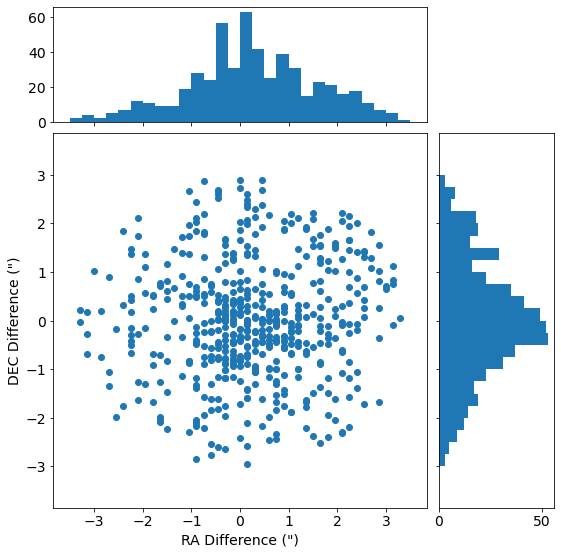

In [68]:
#define a 'fancy' scatter+histogram plot
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25 #1e-4
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(deltaRA, bins=bins)
    ax_histy.hist(deltaDEC, bins=bins, orientation='horizontal')

    
    
#make the scatter+hist plot for position x-match
plt.rcParams.update({'font.size': 14})

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.02


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(deltaRA, deltaDEC, ax, ax_histx, ax_histy)

ax.set_xlabel('RA Difference (\")')
ax.set_ylabel('DEC Difference (\")')

plt.show()


### check for possible source duplication (multiple matches to the same sources)

In [69]:
#idx
w, c = np.unique(idx, return_counts=True)
w[c > 1]

array([133907, 193776, 234645])

In [70]:
#idx
w, c = np.unique(rdx, return_counts=True)
w[c > 1]

array([ 23,  77, 105, 110, 127, 163, 171, 174, 182, 230, 324, 375, 469,
       595, 599, 626, 688, 839, 858, 895, 896, 946])

In [71]:
#above cells show that some sources are being double counted 
#this function will ensure that only the closest match will be counted and the more distant matches will not be returned. 
def remove_duplicates2(cat1,cat2,radius):
    
    #get source coordinates from both tables
    sources1=cat1['skycoords']
    sources2=cat2['skycoords']

    #crossmatch source lists to look for duplication
    idx,rdx, d2d, d3d = sources1.search_around_sky(sources2, radius*u.arcsec)
    print('Number of crossmatched sources found: ', len(idx))
    
    order=np.argsort(d2d)
    dvals=d2d[order].arcsec
    idxsort=idx[order]
    rdxsort=rdx[order]
    
    catsort1=cat1[rdxsort]  #this cell is where the changes can be made to swap between tables. 
    catsort2=cat2[idxsort]
    #m37=mcat37snrcut[idxsort]
    #m25['xmatchd2d']=np.round(dvals,3)

    sindex=0
    start=catsort1[:sindex]
    
    
    try:
        colname='SourceID'
        sourceList=list(start[colname])
    except:
        colname='SSTGC'
        sourceList=list(start[colname])
    
    #reject_idx=[]
    #reject_rdx=[]
    #d2d_update=[]
    ivals=[]

    for i in range(sindex+1,len(catsort1)):
        newsid=catsort1[i][colname]

        if newsid not in sourceList:
            sourceList.append(newsid)
        else:
            #print(newsid, " is already in source list!")
            #reject_idx.append(idxsort[i])
            #reject_rdx.append(rdxsort[i])
            #d2d_update.append(dvals[i])
            ivals.append(i)

     
    rdxNoDup=np.delete(rdxsort,ivals)    
    idxNoDup=np.delete(idxsort,ivals) 
    d2dup=np.delete(dvals,ivals)

    cat1nd=cat1[rdxNoDup]
    cat2nd=cat2[idxNoDup]
    
    
    return cat1nd,cat2nd,d2dup

In [72]:
stgccat,matchedmcat,d2dup=remove_duplicates2(sstgc8um,mcat,4.0) #if greater than 4" start getting duplicaiton with SSTGC sources

Number of crossmatched sources found:  643


In [73]:
matchedmcat,stgccat,d2dup=remove_duplicates2(matchedmcat,stgccat,3.0)

Number of crossmatched sources found:  602


In [74]:
len(stgccat)

512

In [75]:
len(matchedmcat)

512

In [76]:
#check to ensure that we aren't double counting sources now
w, c = np.unique(stgccat['SSTGC'], return_counts=True)
w[c > 1]

<MaskedColumn name='SSTGC' dtype='str7' length=0>

In [77]:
#check to ensure that we aren't double counting sources now
w, c = np.unique(matchedmcat['SourceID'], return_counts=True)
w[c > 1]

<Column name='SourceID' dtype='bytes18' length=0>

In [78]:
stgccat

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M,skycoords
,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,mag,mag,,,"deg,deg"
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2,object
0558345,17 45 52.11,-28 47 18.4,10.354,7.426,5.802,--,--,3.473,3.661,IRAC,2M,"266.467125,-28.788444444444448"
0515803,17 45 36.61,-28 59 45.8,--,--,--,--,--,--,6.617,IRAC,2M,"266.4025416666666,-28.996055555555557"
0673798,17 46 34.01,-28 42 46.2,15.855,12.880,9.720,7.191,6.466,5.743,5.558,IRAC,2M,"266.64170833333327,-28.712833333333332"
0667560,17 46 31.70,-28 35 41.2,--,--,--,7.824,6.393,5.374,5.041,IRAC,2M,"266.63208333333324,-28.594777777777775"
0516452,17 45 36.83,-28 59 19.8,--,--,--,--,10.943,9.834,8.658,IRAC,2M,"266.4034583333333,-28.988833333333336"
0648643,17 46 24.87,-29 00 01.3,17.327,13.881,10.972,7.673,6.394,5.281,4.893,IRAC,2M,"266.6036249999999,-29.00036111111111"
0521894,17 45 38.82,-28 52 31.9,--,--,--,10.668,9.378,7.410,5.598,IRAC,2M,"266.41175,-28.87552777777778"
0414950,17 44 58.95,-29 16 27.4,10.605,7.348,5.658,--,5.737,3.756,3.708,IRAC,2M,"266.24562499999996,-29.274277777777776"


In [79]:
#Examine the positional accuracy of the cross match
deltaRA=matchedmcat['skycoords'].ra.arcsec - stgccat['skycoords'].ra.arcsec
deltaDEC=matchedmcat['skycoords'].dec.arcsec - stgccat['skycoords'].dec.arcsec

print("Average difference in RA: ", np.mean(deltaRA), ",  Standard deviation of difference: ", np.std(deltaRA))
print("Average difference in DEC: ", np.mean(deltaDEC), ",  Standard deviation of difference: ", np.std(deltaDEC))

Average difference in RA:  0.27011718750190994 ,  Standard deviation of difference:  1.2717158937372464
Average difference in DEC:  0.00845703124932129 ,  Standard deviation of difference:  1.1719915617484244


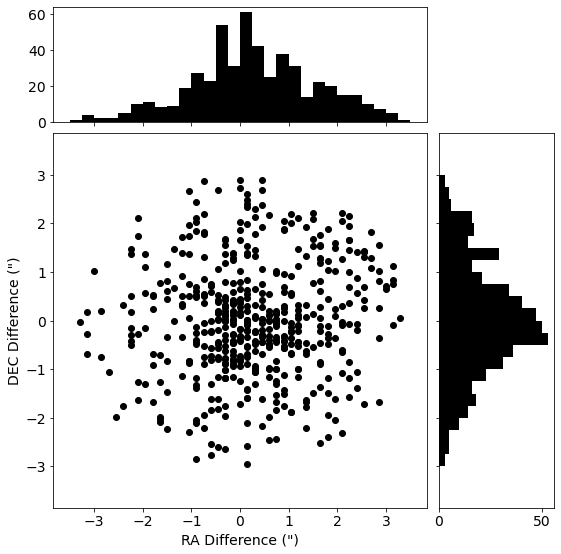

In [80]:
#define a 'fancy' scatter+histogram plot
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,color='k')

    # now determine nice limits by hand:
    binwidth = 0.25 #1e-4
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(deltaRA, bins=bins,color='k')
    ax_histy.hist(deltaDEC, bins=bins, orientation='horizontal',color='k')

    
    
#make the scatter+hist plot for position x-match
plt.rcParams.update({'font.size': 14})

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.02


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(deltaRA, deltaDEC, ax, ax_histx, ax_histy)

ax.set_xlabel('RA Difference (\")')
ax.set_ylabel('DEC Difference (\")')

#plt.savefig("AstrometryCrossmatch.pdf",dpi=300)

plt.show()


In [81]:
stgccat

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M,skycoords
,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,mag,mag,,,"deg,deg"
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2,object
0558345,17 45 52.11,-28 47 18.4,10.354,7.426,5.802,--,--,3.473,3.661,IRAC,2M,"266.467125,-28.788444444444448"
0515803,17 45 36.61,-28 59 45.8,--,--,--,--,--,--,6.617,IRAC,2M,"266.4025416666666,-28.996055555555557"
0673798,17 46 34.01,-28 42 46.2,15.855,12.880,9.720,7.191,6.466,5.743,5.558,IRAC,2M,"266.64170833333327,-28.712833333333332"
0667560,17 46 31.70,-28 35 41.2,--,--,--,7.824,6.393,5.374,5.041,IRAC,2M,"266.63208333333324,-28.594777777777775"
0516452,17 45 36.83,-28 59 19.8,--,--,--,--,10.943,9.834,8.658,IRAC,2M,"266.4034583333333,-28.988833333333336"
0648643,17 46 24.87,-29 00 01.3,17.327,13.881,10.972,7.673,6.394,5.281,4.893,IRAC,2M,"266.6036249999999,-29.00036111111111"
0521894,17 45 38.82,-28 52 31.9,--,--,--,10.668,9.378,7.410,5.598,IRAC,2M,"266.41175,-28.87552777777778"
0414950,17 44 58.95,-29 16 27.4,10.605,7.348,5.658,--,5.737,3.756,3.708,IRAC,2M,"266.24562499999996,-29.274277777777776"


In [82]:
#add crossmatch information for SSTGC catalog
matchedmcat['SSTGCxmatch']=stgccat["SSTGC"]
matchedmcat['SSTGCd2d']=np.round(d2dup,3)

matchedmcat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,M2D25_qflag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,G2D25_qflag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,M2D37_qflag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,G2D37_qflag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id,skycoords,SSTGCxmatch,SSTGCd2d
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,"deg,deg",,
bytes18,bytes12,bytes13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,bytes18,bytes18,int32,int32,int32,float32,bytes3,float32,float32,float32,bytes3,float32,float32,float32,int32,object,str7,float64
SFGC0.154+0.0305,17h45m52.11s,-28d47m18.29s,a,1.215,0.07536,16.12,2.91,0.1507,19.31,4.134,0.2261,18.29,2.395,1.421,--,--,--,--,1.0,3.369,0.1399,24.08,1.72,0,8.166,--,1.192,0.02142,0,0,0,0.012317061 .. 0.010174385,-- .. --,-0.00020164582 .. -0.010862777,a,1.735,0.4041,4.294,4.79,0.7714,6.21,6.848,1.029,6.658,2.761,1.43,--,--,--,--,1,4.02,0.7758,5.181,1.277,0,11.61,--,1.708,0,0,0,0.02826,0.102191195 .. 0.010739732,-- .. --,0.0066655492 .. -0.01574394,"266.467125,-28.788413888888893",Field20,SFGC0.154+0.0305,--,0,1,0,--,000,--,--,--,000,--,--,--,613,"266.467125,-28.78841388888889",0558345,0.11
SFGC359.948-0.0293,17h45m36.60s,-28d59m45.80s,a,1.934,0.274,7.058,4.92,0.548,8.978,8.436,0.822,10.26,2.544,1.715,--,--,--,--,1.0,6.087,0.6909,8.81,4.124,0,11.09,--,1.585,0.02142,0,1,0,0.050377894 .. -0.013156525,-- .. --,0.024666041 .. -0.011547057,a,10.11,1.17,8.638,27.95,2.234,12.51,42.42,2.978,14.24,2.766,1.518,--,--,--,--,1,23.4,2.909,8.045,2.748,0,15.03,--,1.296,1,0,0,0.02826,0.26187968 .. -0.06528417,-- .. --,0.04126874 .. -0.004408556,"266.4025,-28.99605555555556",Field41,SFGC359.948-0.0293,--,0,1,0,--,000,--,--,--,000,--,--,--,531,"266.4025,-28.996055555555557",0515803,0.131
SFGC0.299-0.0610,17h46m34.02s,-28d42m46.19s,g,0.3175,0.06646,4.778,--,--,--,--,--,--,--,--,--,--,--,--,1.0,0.3584,0.03986,8.992,1.723,0,2.637,0.948,1.285,0.02142,0,0,0,0.0046728295 .. -0.010867304,-- .. --,0.0044102594 .. -0.00626117,a,--,--,--,--,--,--,--,--,--,--,--,0.1374,0.04258,3.227,1.665,0,0.1319,0.04041,3.265,1.663,0,1.522,--,1.363,0,0,0,0.02826,-0.00489589 .. -0.013288289,-0.0020012243 .. -0.034825362,-0.0020012243 .. -0.034825362,"266.64174999999994,-28.712830555555556",Field11,SFGC0.299-0.0610,--,0,1,0,--,011,--,0.4146,0.6221,111,0.4761,0.9087,1.212,672,"266.64174999999994,-28.712830555555556",0673798,0.132
SFGC0.395+0.0076,17h46m31.71s,-28d35m41.19s,g,0.9391,0.05525,17,1.528,0.1105,13.83,2.129,0.1658,12.85,1.627,1.394,1.691,0.03149,53.69,0.9483,0.0,1.154,0.04685,24.62,1.156,0,3.729,0.3669,1.1,0.02373,0,0,1,-0.0041721943 .. 0.003347520

In [83]:
matchsid=list(matchedmcat['id'])

i=0
rdx2=[]
for source in mcat:
    
    if source['id'] in matchsid:
        #print(i)
        rdx2.append(i)
        
    i=i+1

In [84]:
len(rdx2)

512

In [85]:
#find sources in mcat that were not found in the cross match with SSTGC catalog
notrdx=findNOTindex(mcat,rdx2)
onlymcat=mcat[notrdx]
#set entries for non-matched sources to NULL
onlymcat['SSTGCxmatch']=''

In [86]:
#Optional - write out a set of ds9 region files for matched and unmatched sources - useful for visual comparison
##set size of regions 
#r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
##write out ds9 files
#makeDS9reg('mcat_matched_SSTGC.reg', matchedmcat, r, color='cyan');
#makeDS9reg('mcat_nonmatched_SSTGC.reg', onlymcat, r, color='red');

In [87]:
#create a combined table of both matched and unmatched sources
mcatComb=vstack((matchedmcat,onlymcat))

#print combined table
mcatComb

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,M2D25_qflag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,G2D25_qflag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,M2D37_qflag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,G2D37_qflag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id,skycoords,SSTGCxmatch,SSTGCd2d
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,"deg,deg",,
bytes18,bytes12,bytes13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,bytes18,bytes18,int32,int32,int32,float32,bytes3,float32,float32,float32,bytes3,float32,float32,float32,int32,object,str7,float64
SFGC0.154+0.0305,17h45m52.11s,-28d47m18.29s,a,1.215,0.07536,16.12,2.91,0.1507,19.31,4.134,0.2261,18.29,2.395,1.421,--,--,--,--,1.0,3.369,0.1399,24.08,1.72,0,8.166,--,1.192,0.02142,0,0,0,0.012317061 .. 0.010174385,-- .. --,-0.00020164582 .. -0.010862777,a,1.735,0.4041,4.294,4.79,0.7714,6.21,6.848,1.029,6.658,2.761,1.43,--,--,--,--,1,4.02,0.7758,5.181,1.277,0,11.61,--,1.708,0,0,0,0.02826,0.102191195 .. 0.010739732,-- .. --,0.0066655492 .. -0.01574394,"266.467125,-28.788413888888893",Field20,SFGC0.154+0.0305,,0,1,0,--,000,--,--,--,000,--,--,--,613,"266.467125,-28.78841388888889",0558345,0.11
SFGC359.948-0.0293,17h45m36.60s,-28d59m45.80s,a,1.934,0.274,7.058,4.92,0.548,8.978,8.436,0.822,10.26,2.544,1.715,--,--,--,--,1.0,6.087,0.6909,8.81,4.124,0,11.09,--,1.585,0.02142,0,1,0,0.050377894 .. -0.013156525,-- .. --,0.024666041 .. -0.011547057,a,10.11,1.17,8.638,27.95,2.234,12.51,42.42,2.978,14.24,2.766,1.518,--,--,--,--,1,23.4,2.909,8.045,2.748,0,15.03,--,1.296,1,0,0,0.02826,0.26187968 .. -0.06528417,-- .. --,0.04126874 .. -0.004408556,"266.4025,-28.99605555555556",Field41,SFGC359.948-0.0293,,0,1,0,--,000,--,--,--,000,--,--,--,531,"266.4025,-28.996055555555557",0515803,0.131
SFGC0.299-0.0610,17h46m34.02s,-28d42m46.19s,g,0.3175,0.06646,4.778,--,--,--,--,--,--,--,--,--,--,--,--,1.0,0.3584,0.03986,8.992,1.723,0,2.637,0.948,1.285,0.02142,0,0,0,0.0046728295 .. -0.010867304,-- .. --,0.0044102594 .. -0.00626117,a,--,--,--,--,--,--,--,--,--,--,--,0.1374,0.04258,3.227,1.665,0,0.1319,0.04041,3.265,1.663,0,1.522,--,1.363,0,0,0,0.02826,-0.00489589 .. -0.013288289,-0.0020012243 .. -0.034825362,-0.0020012243 .. -0.034825362,"266.64174999999994,-28.712830555555556",Field11,SFGC0.299-0.0610,,0,1,0,--,011,--,0.4146,0.6221,111,0.4761,0.9087,1.212,672,"266.64174999999994,-28.712830555555556",0673798,0.132
SFGC0.395+0.0076,17h46m31.71s,-28d35m41.19s,g,0.9391,0.05525,17,1.528,0.1105,13.83,2.129,0.1658,12.85,1.627,1.394,1.691,0.03149,53.69,0.9483,0.0,1.154,0.04685,24.62,1.156,0,3.729,0.3669,1.1,0.02373,0,0,1,-0.0041721943 .. 0.0033475205,0.00

In [88]:
#Get matching catalog that includes extinction information
os.getcwd()
os.chdir('C:/Users/mhankins1/Downloads')

angcat=Table.read('SFGC_MasterCatalog.fits')

In [89]:
#check that indices for sources match between both tables. 
flag=0
for i in range(len(mcatComb)):
    if not mcatComb['SourceID'][i]==angcat['SourceID'][i]:
        print('\n mismatch!')
        print(mcatComb['SourceID'][i])
        print(angcat['SourceID'][i])

In [90]:
#add extinction information to table
mcatComb['tau_9.6'] = angcat['tau_9.6']
mcatComb['tau_distance'] = angcat['tau_distance']

In [91]:
#change directory back to data
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [92]:
#clean up table before writing out
if 'sky_centroid' in mcatComb.columns:
    mcatComb.remove_columns('sky_centroid')
    
#keep skycoords for next steps...
#if 'skycoords' in mcatComb.columns:
#    mcatComb.remove_columns('skycoords')
    
if 'id' in mcatComb.columns:
    mcatComb.remove_columns('id')


In [93]:
#write out final catalog
mcatComb.write('masterCat_combined_step4.fits',overwrite=True)

In [94]:
#remove cutouts from table
if 'cutout25' in mcatComb.columns:
    mcatComb.remove_columns('cutout25')
    
if 'M2Dresid25' in mcatComb.columns:
    mcatComb.remove_columns('M2Dresid25')
    
if 'G2Dresid25' in mcatComb.columns:
    mcatComb.remove_columns('G2Dresid25')
    
if 'cutout37' in mcatComb.columns:
    mcatComb.remove_columns('cutout37')
    
if 'M2Dresid37' in mcatComb.columns:
    mcatComb.remove_columns('M2Dresid37')
    
if 'G2Dresid37' in mcatComb.columns:
    mcatComb.remove_columns('G2Dresid37')

In [95]:
#write out final catalog
mcatComb.write('masterCat_combined_step4_NoCutouts.fits',overwrite=True)